In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy import signal
import matplotlib.pyplot as plt
import itertools
import os
from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy import stats
import warnings
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
pd.options.display.max_rows = 999
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

df = pd.read_csv('table_base.csv', index_col='No. overall')
nums=df.reset_index()[['Season','No. overall']].groupby('Season').min()
nums['No. overall']-=1

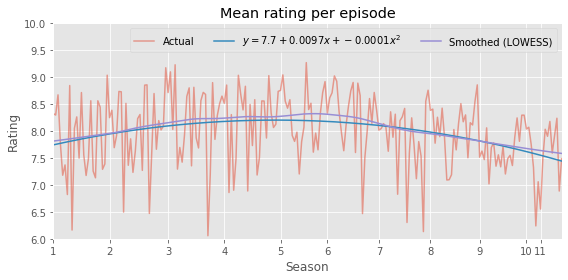

In [42]:
import statsmodels.api as sm
import scipy.stats as scs

nums=df.reset_index()[['Season','No. overall']].groupby('Season').min()
nums['No. overall']-=1

X_plot=pd.DataFrame({'num':list(range(df.shape[0]))})

y_plot=df.reset_index()['mean']
X_plot=sm.add_constant(X_plot)

for j in [2]:
    X_plot['^' + str(j)]=X_plot['num']**j

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()

fig,ax=plt.subplots(figsize=(8,4))

lowess = sm.nonparametric.lowess
w = lowess(y_plot, X_plot['num'], frac=0.3)

df_=simple_results.params*X_plot
ax.plot(X_plot['num'],y_plot,alpha=0.5,label='Actual')
ax.plot(X_plot['num'],df_.sum(axis=1),label = ("$y = {} + {}x + {}x^2$").format(round(simple_results.params[0],1),round(simple_results.params[1],4),round(simple_results.params[2],4)))

ax.plot(X_plot['num'],w[:,1],label='Smoothed (LOWESS)')
ax.legend(ncol=3)
ax.set_xticks(nums['No. overall'])
ax.set_xticklabels(nums.index)
ax.set_xlabel('Season')
ax.set_ylabel('Rating')
ax.set_title('Mean rating per episode')
ax.set_ylim(6,10)


fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('img/ratings_1.svg',bbox_inches = 'tight')

In [43]:
ind1=np.array(df.reset_index()[['Season','No. overall']].groupby('Season').transform(lambda x: x<x.quantile(0.25))['No. overall'])
ind2=np.array(df.reset_index()[['Season','No. overall']].groupby('Season').transform(lambda x: x>x.quantile(0.75))['No. overall'])

In [44]:
ind3=ind1 + ind2

In [45]:
perc_tups=[]
tup1=None
for i,j in enumerate(ind3):
    if j and not tup1:
        tup1=i
    elif j and tup1:
        continue
    elif not j and tup1:
        tup2=i-1
        perc_tups.append((tup1,tup2))
        tup1=None
    elif not j and not tup1:
        continue

perc_tups.append((tup1,df.shape[0]))

In [46]:
df_ridge=pd.read_csv('ridge.csv',index_col=0)

In [47]:
df_ridge=df_ridge[(df_ridge['x']>0) & (df_ridge['x']<=df.index.max())]

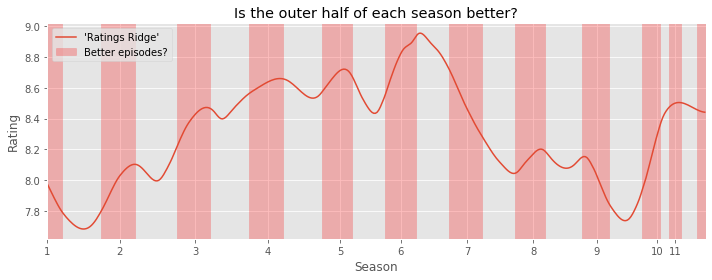

In [48]:
fig,ax=plt.subplots(figsize=(10,4))
# ax.plot(X_plot['num'],y_plot,alpha=1,label='Actual')
ax.plot(df_ridge['x'],df_ridge['y'],label="'Ratings Ridge'")
ax.axvspan(0, perc_tups[0][1], alpha=0.25, color='red',label='Better episodes?')
for i in perc_tups[1:]:
    ax.axvspan(i[0], i[1], alpha=0.25, color='red')
ax.set_xlabel('Season')
ax.set_ylabel('Rating')
ax.set_xticks(nums['No. overall'])
ax.set_xticklabels(nums.index)
ax.set_title('Is the outer half of each season better?')
ax.legend()

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('img/ridge_hyp1.svg',bbox_inches = 'tight')

In [49]:
import ast
lst_tmp=[ast.literal_eval(i) for i in df[ind3]['ratings']]
outer_dist=[i for sublist in lst_tmp for i in sublist]

lst_tmp=[ast.literal_eval(i) for i in df[~ind3]['ratings']]
inner_dist=[i for sublist in lst_tmp for i in sublist]

In [50]:
import scipy.stats as stats
stats.mannwhitneyu(outer_dist, inner_dist, alternative="greater")

MannwhitneyuResult(statistic=52137078728.5, pvalue=0.0)

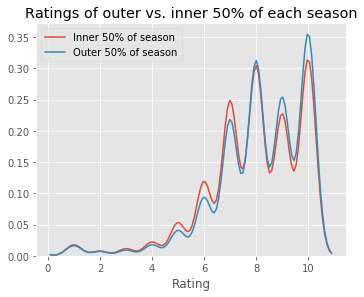

In [51]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(5,4))
ax=sns.kdeplot(inner_dist,label='Inner 50% of season',bw=.3)
ax=sns.kdeplot(outer_dist,label='Outer 50% of season',bw=.3)
ax.set_xlabel('Rating')

fig.tight_layout()
ax.set_title('Ratings of outer vs. inner 50% of each season')
# plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('img/ridge_hyp2.svg',bbox_inches = 'tight')

In [52]:
avgs=[]
import ast

for i in range(1,12):
    tmp_lst=[]
    df_tmp=df[df['Season']==i]
    for j in df_tmp['ratings'].values:
        j=ast.literal_eval(j)
        tmp_lst+=j
    avgs.append(tmp_lst.copy())


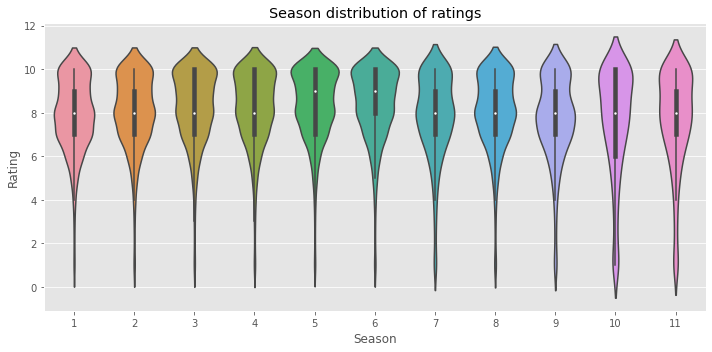

In [53]:
data_df=pd.DataFrame(columns=range(1,12),data=np.empty((103765,11)))

data_df.replace(0.0,np.nan,inplace=True)

for i in range(1,12):
    tmp_df=pd.DataFrame({i:avgs[i-1]})
    data_df.update(tmp_df)

import seaborn as sns
fig,ax=plt.subplots(figsize=(10,5))
ax=sns.violinplot(data=data_df,bw=.3)
ax.set_xlabel('Season')
ax.set_ylabel('Rating')
ax.set_title('Season distribution of ratings')
fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('img/ratings_violin.svg',bbox_inches = 'tight')

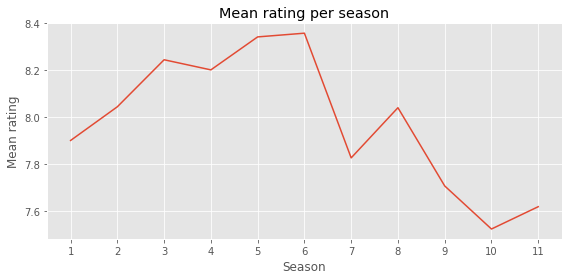

In [54]:
fig,ax=plt.subplots(figsize=(8,4))

ax.plot(range(1,12),[np.mean(i) for i in avgs])
ax.set_xticks(range(1,12))
ax.set_xlabel('Season')
ax.set_ylabel('Mean rating')
ax.set_title('Mean rating per season')

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/season_means.svg',bbox_inches = 'tight')

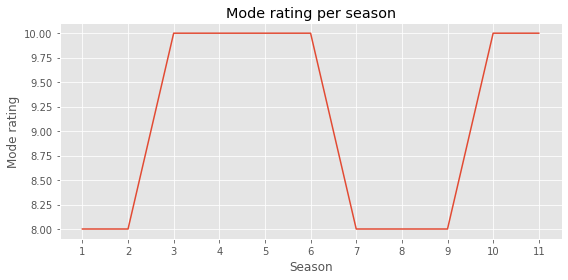

In [55]:
fig,ax=plt.subplots(figsize=(8,4))

ax.plot(range(1,12),[stats.mode(i)[0][0] for i in avgs])
ax.set_xticks(range(1,12))
ax.set_xlabel('Season')
ax.set_ylabel('Mode rating')
ax.set_title('Mode rating per season')

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/season_means.svg',bbox_inches = 'tight')

No handles with labels found to put in legend.
MannwhitneyuResult(statistic=1545470041.0, pvalue=0.0005328067250679541)


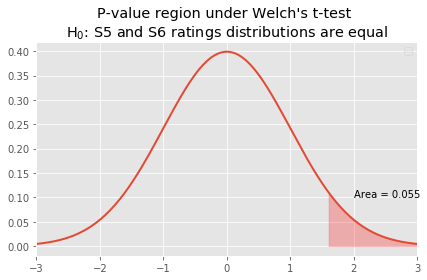

In [56]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

samp1=avgs[5]
samp2=avgs[4]

test_statistic=welch_test_statistic(samp1,samp2)
ws=welch_satterhwaithe_df(samp1,samp2)
students = stats.t(ws)

x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(x, students.pdf(x), linewidth=2)
_ = ax.fill_between(x, students.pdf(x), where=(x >= test_statistic), color="red", alpha=0.25)
# _ = ax.fill_between(x, students.pdf(x), where=(x <= test_statistic), color="red", alpha=0.25)
ax.legend()
ax.set_title("P-value region under Welch's t-test \nH"  + r'$_0$' + ': S5 and S6 ratings distributions are equal')
ax.text(2,.1,'Area = {:.3f}'.format(1 - students.cdf(test_statistic)))
fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/s5_s6_welch.svg',bbox_inches = 'tight')

print (stats.mannwhitneyu(samp1, samp2, alternative="greater"))

In [57]:

ranked=sorted([(np.mean(avgs[i]),i) for i in range(len(avgs))],reverse=True)
rank_order=[i[1] for i in ranked]

def p_vals(samp1,samp2):
    test_statistic=welch_test_statistic(samp1,samp2)
    ws=welch_satterhwaithe_df(samp1,samp2)
    students = stats.t(ws)
    w=1 - students.cdf(test_statistic)
    m=stats.mannwhitneyu(samp1, samp2, alternative="greater")
    return w,m[1]

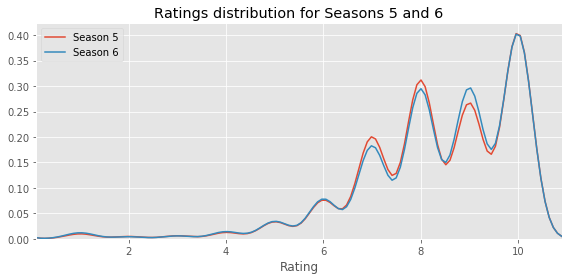

In [58]:
fig,ax=plt.subplots(figsize=(8,4))
ax=sns.kdeplot(avgs[4],bw=.3,label='Season 5')
ax=sns.kdeplot(avgs[5],bw=.3,label='Season 6')
ax.set_xlabel('Rating')
ax.set_title('Ratings distribution for Seasons 5 and 6')

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/s5_s6_kde.svg',bbox_inches = 'tight')

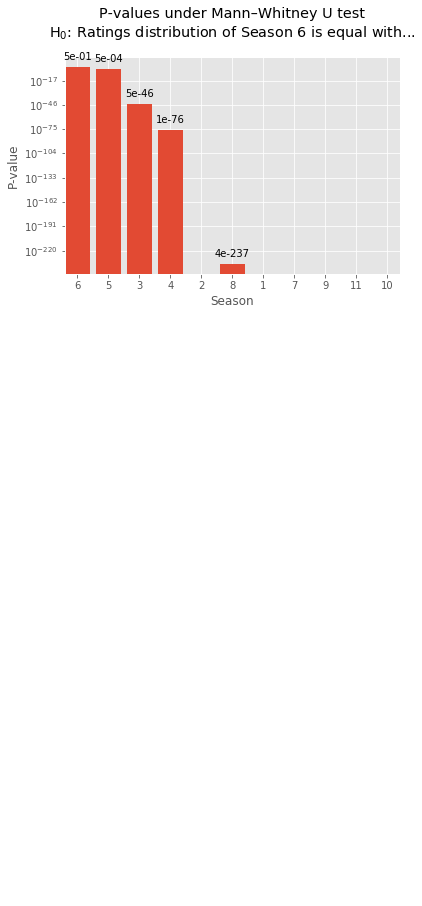

In [59]:
pvals=[]
for i in rank_order:
    pvals.append(p_vals(avgs[5],avgs[i]))

wmu=np.vstack(pvals)[:,1]

def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.0e}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      
                                        

fig,ax=plt.subplots()

ax.bar(range(len(wmu[0:])),wmu[0:])
# ax.set_ylim(0,1)
ax.set_yscale('log')
add_value_labels(ax)
ax.set_title('P-values under Mann–Whitney U test\nH' + r'$_0$' + ': Ratings distribution of Season 6 is equal with...',pad=20)
ax.set_xlabel('Season')
ax.set_ylabel('P-value')
ax.set_xticks(range(11))
ax.set_xticklabels(np.array(rank_order) + 1)

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/s6_mwu.png',dpi=1000,bbox_inches = 'tight')

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
pd.options.display.max_rows = 999
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

df=pd.read_csv('table_base.csv',index_col='No. overall')

df=df[df['Season']<10]
df['Written by']=df['Written by'].apply(lambda x: x.split(','))
df['Written by']=df['Written by'].apply(lambda x: [i.strip() for i in x])
s = df['Written by']
mlb = MultiLabelBinarizer()
tmp_df=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
tmp_df.rename(columns={i:'Writer ' + i for i in tmp_df.columns},inplace=True)
df.drop(columns='Written by',inplace=True)
df=df.join(tmp_df)
df['Directed by']=df['Directed by'].apply(lambda x: x.split(','))
s = df['Directed by']
mlb = MultiLabelBinarizer()
tmp_df=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
tmp_df.rename(columns={i:'Director ' + i for i in tmp_df.columns},inplace=True)
df.drop(columns='Directed by',inplace=True)
df=df.join(tmp_df)
df.set_index('Production code',inplace=True)
speakers=['MULDER','SCULLY','CSM','KRYCEK','LANGLY','BYERS','FROHIKE','SKINNER','X','DOGGETT','REYES']
for i in speakers:
    df[i]=0
for i in df.index:
    try:
        df2=pd.read_csv('scripts/' + i + '.csv') 
        sums=df2[['speaker','words']].groupby('speaker').sum() 
        sums.reset_index(inplace=True)
        sums['speaker']=sums['speaker'].apply(lambda x: x.strip())
        sums=sums[sums['speaker'].isin(speakers)].T
        to_join=pd.DataFrame(index=[i],data={sums.iloc[0,i]:sums.iloc[1,i] for i in range(sums.shape[1])})
        df.update(to_join)
    except:
        continue
df['Mythology']=df['Mythology'].astype(int)

# df['Ep_mid_distance']=df[['Season','No. in season']].groupby('Season').transform(lambda x: abs( (x-x.mean())/(x.mean()-1) ))

df['Viewers (millions)']=df['Viewers (millions)'].fillna(df['Viewers (millions)'].mean())

df.fillna(0,inplace=True)

df['Season']=(df['Season']-1)/(df['Season'].max()-1)

# df['Season_mid_distance']=abs(df['Season']-df['Season'].median())/(df['Season'].median()-1)

df['Ep_distance']=df[['Season','No. in season']].groupby('Season').transform(lambda x: (x-1)/(x.max()-1))

df=df.select_dtypes(include='number')

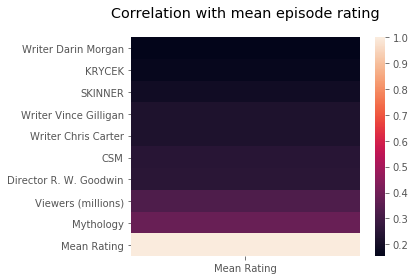

In [61]:
import seaborn as sns
fig,ax=plt.subplots()
df_tmp=df.copy()
df_tmp.rename(columns={'mean':'Mean Rating'},inplace=True)
ax=sns.heatmap(df_tmp.corr()[['Mean Rating']].sort_values('Mean Rating').tail(10))
ax.set_title('Correlation with mean episode rating',pad=20)

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/corr_mean.svg',bbox_inches = 'tight')

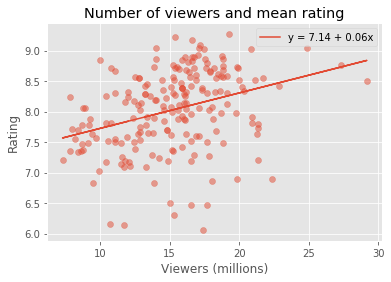

In [62]:
h_vals=[]

import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.stats.diagnostic import het_white

i='Viewers (millions)'
# i='Mythology'

y_plot=df['mean'].values
X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
# X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.2f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title('Number of viewers and mean rating')
plt.xlabel('Viewers (millions)')
plt.ylabel('Rating')
plt.legend()


h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/viewers_rating.svg',bbox_inches = 'tight')

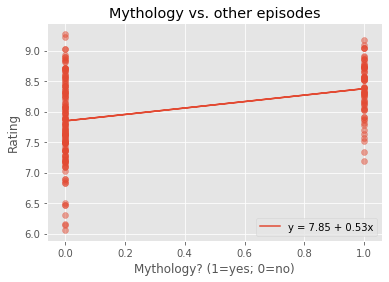

In [63]:
# i='Viewers (millions)'
i='Mythology'

y_plot=df['mean'].values
X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
# X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.2f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title('Mythology vs. other episodes')
plt.xlabel('Mythology? (1=yes; 0=no)')
plt.ylabel('Rating')

plt.legend()

from statsmodels.stats.diagnostic import het_white

h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/myth_rating.svg',bbox_inches = 'tight')

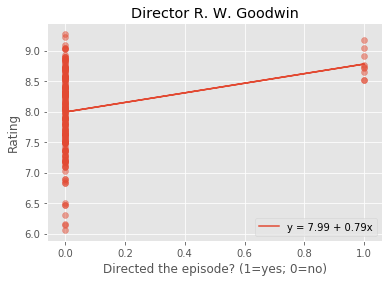

In [64]:
# i='Viewers (millions)'
i='Director R. W. Goodwin'

y_plot=df['mean'].values
# X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.2f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title(i)
plt.xlabel('Directed the episode? (1=yes; 0=no)')
plt.ylabel('Rating')

plt.legend()

from statsmodels.stats.diagnostic import het_white

h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/dir_rating.svg',bbox_inches = 'tight')

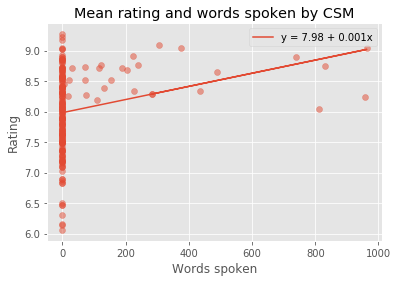

In [65]:
# i='Viewers (millions)'
i='CSM'

y_plot=df['mean'].values
# X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.3f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title('Mean rating and words spoken by CSM')
plt.xlabel('Words spoken')
plt.ylabel('Rating')

plt.legend()

from statsmodels.stats.diagnostic import het_white

h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/csm_rating.svg',bbox_inches = 'tight')

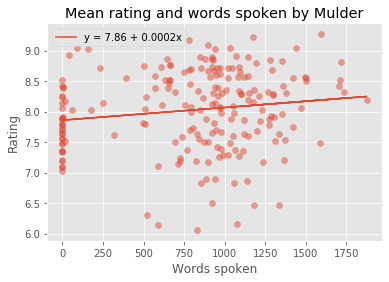

In [66]:
# i='Viewers (millions)'
i='MULDER'

y_plot=df['mean'].values
# X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.4f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title('Mean rating and words spoken by Mulder')
plt.xlabel('Words spoken')
plt.ylabel('Rating')

plt.legend()

from statsmodels.stats.diagnostic import het_white

h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/mulder_rating.svg',bbox_inches = 'tight')

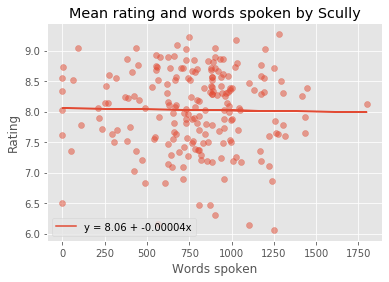

In [67]:
# i='Viewers (millions)'
i='SCULLY'

y_plot=df['mean'].values
# X_plot=sm.add_constant(df[i].fillna(df[i].median()).values)
X_plot=sm.add_constant(df[i].astype(int))

simple_model = sm.OLS(y_plot, X_plot)
simple_results = simple_model.fit()
# simple_results.summary()

plt.scatter(df[i].fillna(df[i].median()).values,y_plot,alpha=0.5)
plt.plot(df[i].fillna(df[i].median()).values,simple_results.params[0]+simple_results.params[1]*df[i].fillna(df[i].median()).values,label='y = {:.2f} + {:.5f}x'.format(simple_results.params[0],simple_results.params[1]))
plt.title('Mean rating and words spoken by Scully')
plt.xlabel('Words spoken')
plt.ylabel('Rating')

plt.legend()

from statsmodels.stats.diagnostic import het_white

h_val1=simple_results.rsquared
# h_val2=linear_harvey_collier(simple_results)[1]
h_val3=stats.shapiro(simple_results.resid)[1]
h_val4=het_white(simple_results.resid, simple_results.model.exog)[3]

h_vals.append((i,h_val1,h_val3,h_val4))

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/scully_rating.svg',bbox_inches = 'tight')

In [68]:
cm = sns.light_palette("green", as_cmap=True)

pd.DataFrame(index=np.vstack(h_vals)[:,0],columns=['Corr. Coeff.','Shapiro-Wilk test p-value','White test p-value'],data=np.vstack(h_vals)[:,1:]).apply(pd.to_numeric).style.background_gradient(cmap=cm)

,Corr. Coeff.,Shapiro-Wilk test p-value,White test p-value
Viewers (millions),0.108857,0.000026,0.219396
Mythology,0.146287,0.185910,0.000515
Director R. W. Goodwin,0.061323,0.001765,0.062724
CSM,0.060740,0.001446,0.283153
MULDER,0.021790,0.000190,0.049488
SCULLY,0.000314,0.000415,0.901173


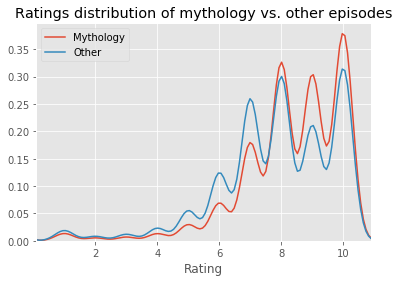

In [69]:
def get_rating_cat(x):
    df=pd.read_csv('table_base.csv',index_col='No. overall')
    df1=df[df[x]==1]['ratings']
    df2=df[df[x]==0]['ratings']
    r1=[]
    for i in df1.values:
        i=ast.literal_eval(i)
        r1+=i
    r2=[]
    for i in df2.values:
        i=ast.literal_eval(i)
        r2+=i
    return r1,r2

dists=get_rating_cat('Mythology')

ax=sns.kdeplot(dists[0],bw=.3,label='Mythology')
ax=sns.kdeplot(dists[1],bw=.3,label='Other')
ax.set_xlabel('Rating')
ax.set_title('Ratings distribution of mythology vs. other episodes')

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/myth_kde.svg',bbox_inches = 'tight')


In [70]:
import scipy.stats as stats

def avg_pval(f):
    V1=df[(df[f]>0)]
    V2=df[(df[f]==0)]
    p=stats.mannwhitneyu(V1['mean'], V2['mean'], alternative="greater")[1]
    val1=V1['mean'].mean()
    val2=V2['mean'].mean()
    return val1,val2,val1-val2,p

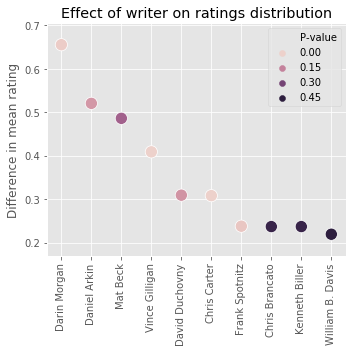

In [71]:
import matplotlib.pyplot as plt
writers_lst=df.columns[df.columns.str.contains('Writer')]

vals=[]
for i in writers_lst:
    vals.append(avg_pval(i))

writers_pvals=pd.DataFrame(index=writers_lst,columns=['Avg with','Avg w/o','Diff','P-value'],data=np.vstack(vals))

w_plot=writers_pvals.sort_values(by='Diff',ascending=False)[['Diff','P-value']].head(10)

import seaborn as sns
fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(w_plot.shape[0]),w_plot['Diff'],hue=w_plot['P-value'],s=150)#size=w_plot['P-value'],linewidth=0)
ax.set_title('Effect of writer on ratings distribution')
ax.set_ylabel('Difference in mean rating')
plt.xticks(range(w_plot.shape[0]),[i.replace('Writer ','') for i in list(w_plot.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/mwu_writer.svg',bbox_inches = 'tight')

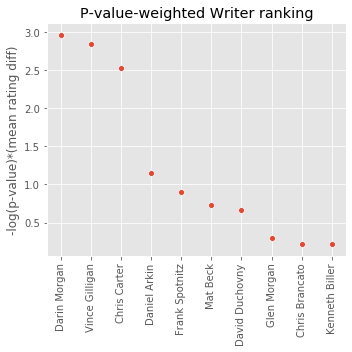

In [72]:
writers_pvals['score']=writers_pvals['Diff']*-np.log(writers_pvals['P-value'])
w_plot2=writers_pvals.sort_values(by='score',ascending=False).head(10)

fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(w_plot2.shape[0]),w_plot2['score'])#size=w_plot['P-value'],linewidth=0)
ax.set_title('P-value-weighted Writer ranking')
ax.set_ylabel('-log(p-value)*(mean rating diff)')
plt.xticks(range(w_plot2.shape[0]),[i.replace('Writer ','') for i in list(w_plot2.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/rank_writer.svg',bbox_inches = 'tight')

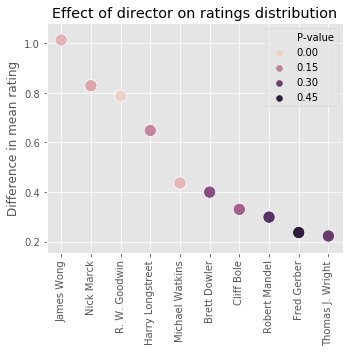

In [73]:
dirs_lst=df.columns[df.columns.str.contains('Director')]

vals=[]
for i in dirs_lst:
    vals.append(avg_pval(i))

dirs_pvals=pd.DataFrame(index=dirs_lst,columns=['Avg with','Avg w/o','Diff','P-value'],data=np.vstack(vals))

d_plot=dirs_pvals.sort_values(by='Diff',ascending=False)[['Diff','P-value']].head(10)

import seaborn as sns
fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(d_plot.shape[0]),d_plot['Diff'],hue=d_plot['P-value'],s=150)#size=d_plot['P-value'])
ax.set_title('Effect of director on ratings distribution')
ax.set_ylabel('Difference in mean rating')
plt.xticks(range(d_plot.shape[0]),[i.replace('Director ','') for i in list(d_plot.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/mwu_director.svg',bbox_inches = 'tight')

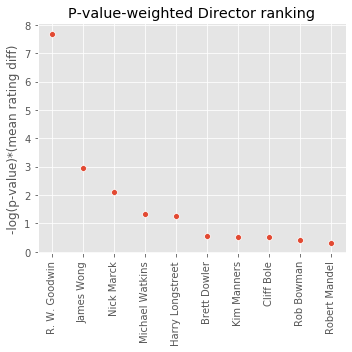

In [74]:
dirs_pvals['score']=dirs_pvals['Diff']*-np.log(dirs_pvals['P-value'])
d_plot2=dirs_pvals.sort_values(by='score',ascending=False).head(10)

fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(d_plot2.shape[0]),d_plot2['score'])#size=w_plot['P-value'],linewidth=0)
ax.set_title('P-value-weighted Director ranking')
ax.set_ylabel('-log(p-value)*(mean rating diff)')
plt.xticks(range(d_plot2.shape[0]),[i.replace('Director ','') for i in list(d_plot2.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/rank_director.svg',bbox_inches = 'tight')

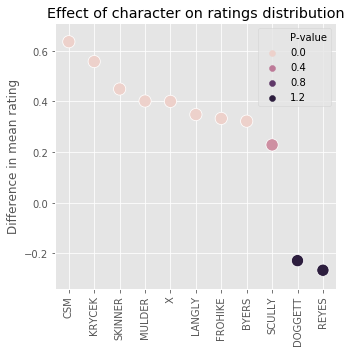

In [75]:
vals=[]
for i in speakers:
    vals.append(avg_pval(i))

chars_pvals=pd.DataFrame(index=speakers,columns=['Avg with','Avg w/o','Diff','P-value'],data=np.vstack(vals))

c_plot=chars_pvals.sort_values(by='Diff',ascending=False)[['Diff','P-value']]

import seaborn as sns
fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(c_plot.shape[0]),c_plot['Diff'],hue=c_plot['P-value'],s=150)#,size=c_plot['P-value'])
ax.set_title('Effect of character on ratings distribution')
ax.set_ylabel('Difference in mean rating')
plt.xticks(range(c_plot.shape[0]),[i for i in list(c_plot.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/mwu_character.svg',bbox_inches = 'tight')

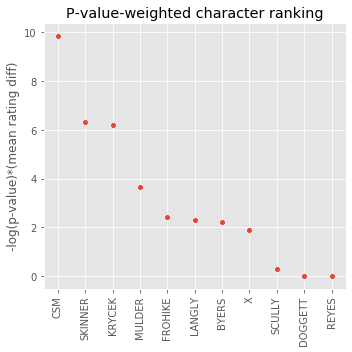

In [76]:
chars_pvals['score']=chars_pvals['Diff']*-np.log(chars_pvals['P-value'])
c_plot2=chars_pvals.sort_values(by='score',ascending=False)

fig,ax=plt.subplots(figsize=(5,5))
ax=sns.scatterplot(range(c_plot2.shape[0]),c_plot2['score'])#size=w_plot['P-value'],linewidth=0)
ax.set_title('P-value-weighted character ranking')
ax.set_ylabel('-log(p-value)*(mean rating diff)')
plt.xticks(range(c_plot2.shape[0]),[i for i in list(c_plot2.index)],rotation=90)

fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/rank_characters.svg',bbox_inches = 'tight')

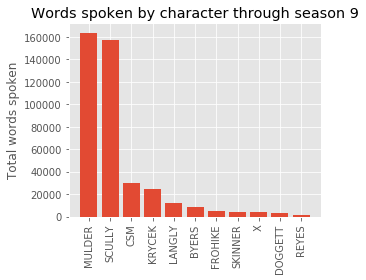

In [77]:
fig,ax=plt.subplots(figsize=(5,4))
speaker_vals=df[speakers].sum().sort_values(ascending=False)

ax.bar(range(len(speakers)),speaker_vals)
ax.set_xticks(range(len(speakers)))
ax.set_xticklabels(speakers,rotation=90)
ax.set_ylabel('Total words spoken')
ax.set_title('Words spoken by character through season 9')
fig.tight_layout()
# plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/words_all.svg',bbox_inches = 'tight')

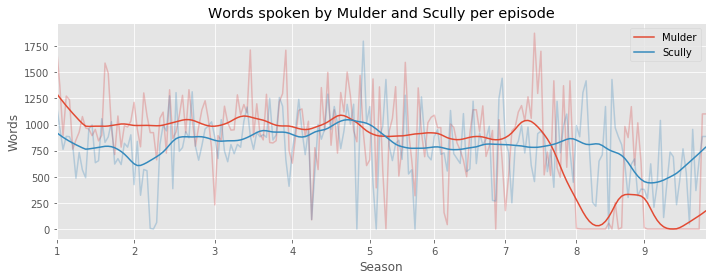

In [78]:
fig,ax=plt.subplots(figsize=(10,4))

ax.plot(range(df.shape[0]),df['MULDER'],alpha=0.25,color='tab:red')
ax.plot(range(df.shape[0]),df['SCULLY'],alpha=0.25,color='tab:blue')

lowess = sm.nonparametric.lowess
w1 = lowess(df['MULDER'], range(df.shape[0]), frac=0.1)

ax.plot(range(df.shape[0]),w1[:,1],label='Mulder')

lowess = sm.nonparametric.lowess
w2 = lowess(df['SCULLY'], range(df.shape[0]), frac=0.1)

ax.plot(range(df.shape[0]),w2[:,1],label='Scully')
ax.legend()

ax.set_xticks(list(nums['No. overall'])[:-2])
ax.set_xticklabels(list(nums.index)[:-2])
ax.set_xlabel('Season')
ax.set_ylabel('Words')
ax.set_title('Words spoken by Mulder and Scully per episode')

fig.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('img/words_mulder_scully.svg',bbox_inches = 'tight')

In [79]:
myth_eps=list(df['Mythology'])

In [80]:
myth_tups=[]

t1=None
for i,j in enumerate(myth_eps):
    if j and not t1:
        t1=i
    elif j and t1:
        continue
    elif not j and t1:
        t2=i
        myth_tups.append((t1,t2))
        t1=None
    elif not j and not t1:
        continue
        